# Basic EDA

Number of samples in training data: 220025
                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                          image_path  
0  /kaggle/input/histopathologic-cancer-detection...  
1  /kaggle/input/histopathologic-cancer-detection...  
2  /kaggle/input/histopathologic-cancer-detection...  
3  /kaggle/input/histopathologic-cancer-detection...  
4  /kaggle/input/histopathologic-cancer-detection...  

Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64


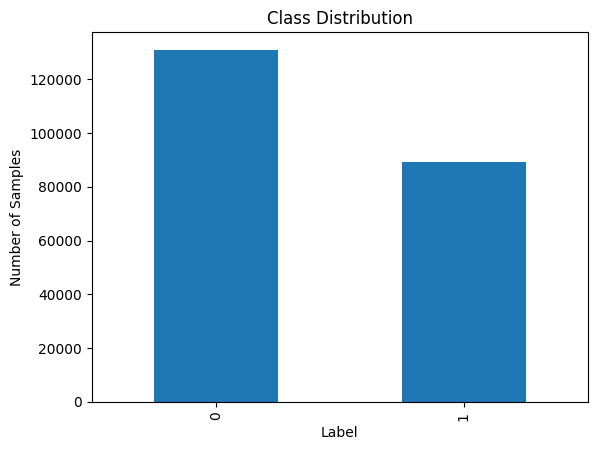

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

data_path = '/kaggle/input/histopathologic-cancer-detection'

train_dir = os.path.join(data_path, 'train')
train_labels_df = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

train_labels_df['image_path'] = train_labels_df['id'].apply(lambda x: os.path.join(train_dir, x + '.tif'))

print(f'Number of samples in training data: {len(train_labels_df)}')

print(train_labels_df.head())

print("\nClass distribution:")
print(train_labels_df['label'].value_counts())

# Class distribution visualization
train_labels_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()

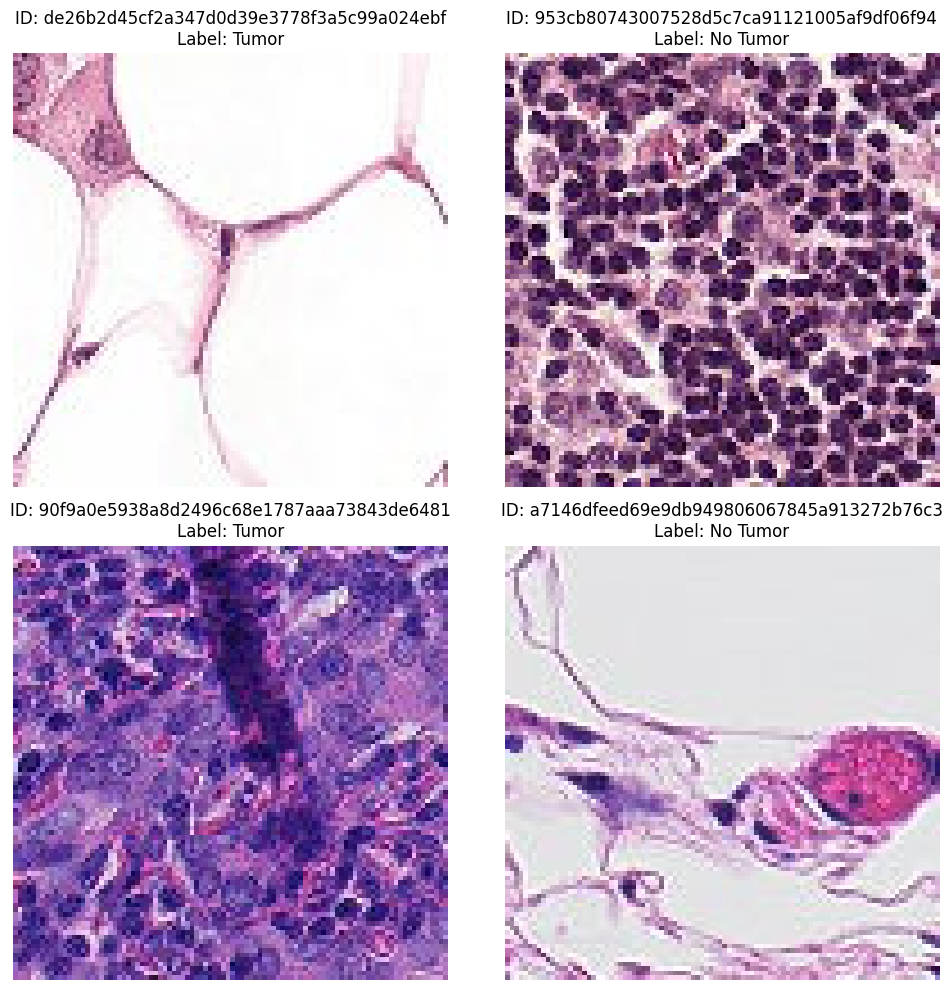

In [23]:
import random
from PIL import Image

train_images_dir = os.path.join(data_path, 'train')

random_image_ids = random.sample(train_labels_df['id'].tolist(), 4)

plt.figure(figsize=(10, 10))

for i, image_id in enumerate(random_image_ids):
    image_path = os.path.join(train_images_dir, f'{image_id}.tif')

    try:
        img = Image.open(image_path)

        label = train_labels_df[train_labels_df['id'] == image_id]['label'].iloc[0]
        label_text = 'Tumor' if label == 1 else 'No Tumor'

        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f'ID: {image_id}\nLabel: {label_text}')
        plt.axis('off')

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while processing image {image_id}: {e}")

plt.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, random_state=42, stratify=train_labels_df['label'])

# Check the size of the training and validation sets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Check the label distribution in the training and validation sets (optional, but good practice)
print("\nTraining set label distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nValidation set label distribution:")
print(val_df['label'].value_counts(normalize=True))


Training set size: 176020
Validation set size: 44005

Training set label distribution:
label
0    0.594966
1    0.405034
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.594978
1    0.405022
Name: proportion, dtype: float64


In [25]:
import tensorflow as tf
import tifffile

# --- Configuration ---
IMG_SIZE = 96 # The images are 96x96 pixels
BATCH_SIZE = 64 # Process images in batches of 64
AUTOTUNE = tf.data.AUTOTUNE # Let tf.data optimize performance automatically

# --- Function to Load and Preprocess using tifffile ---
def decode_tiff_image(image_path):
    # Decode the image path tensor to a Python string
    image_path = image_path.numpy().decode('utf-8')
    # Read the TIFF file using tifffile
    image = tifffile.imread(image_path)
    return image.astype('float32') # Ensure it's float32 for division

def load_and_preprocess_image(image_path, label):
    # 1. Use tf.py_function to wrap the Python decoding function
    #    We need to specify the output type (tf.float32)
    [img,] = tf.py_function(decode_tiff_image, [image_path], [tf.float32])

    # 2. Set the shape explicitly - tf.py_function loses shape info
    #    Images are 96x96 with 3 color channels (RGB)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])

    # 3. Resize (might be redundant if tifffile reads them correctly, but safe to keep)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # 4. Normalize pixel values
    img = img / 255.0
    return img, label

# --- Function for Data Augmentation ---
def augment_image(image, label):
    # Apply random transformations ONLY during training
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(image)
    # You could add rotations, brightness changes, etc. here
    # img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return img, label

# --- Create tf.data.Dataset objects ---
# 1. Create datasets from our pandas DataFrames
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))

# --- Build the Training Pipeline ---
print("Building Training Pipeline...")
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_df)) # Shuffle the training data
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) # Load and preprocess images in parallel
    .map(augment_image, num_parallel_calls=AUTOTUNE) # Apply augmentations
    .batch(BATCH_SIZE) # Group images into batches
    .prefetch(buffer_size=AUTOTUNE) # Prepare next batches while the GPU is busy
)
print("Training Pipeline Built.")

# --- Build the Validation Pipeline ---
print("Building Validation Pipeline...")
val_ds = (
    val_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) # Load and preprocess
    # NO shuffling or augmentation for validation! We want consistent evaluation.
    .batch(BATCH_SIZE) # Group into batches
    .prefetch(buffer_size=AUTOTUNE) # Prepare next batches
)
print("Validation Pipeline Built.")

# --- Check a batch ---
print("\nChecking one batch from the training dataset:")
for images, labels in train_ds.take(1): # Take just one batch
    print("Images batch shape:", images.shape) # Should be (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
    print("Labels batch shape:", labels.shape) # Should be (BATCH_SIZE,)
    print("Labels in batch:", labels.numpy())

Building Training Pipeline...
Training Pipeline Built.
Building Validation Pipeline...
Validation Pipeline Built.

Checking one batch from the training dataset:
Images batch shape: (64, 96, 96, 3)
Labels batch shape: (64,)
Labels in batch: [0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1
 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0]



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

This is taking too long, we give up.


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

This is taking too long, we give up.



In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# --- Constants ---
IMG_SIZE = 96
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3) # Height, Width, Color Channels

# --- Step 1: Load Pretrained Base Model ---

# Load MobileNetV2 pre-trained on ImageNet
# - input_shape: Match our image dimensions
# - include_top=False: Remove the original 1000-class ImageNet classifier
# - weights='imagenet': Use the pre-trained weights
# - pooling='avg': Add a Global Average Pooling layer at the end.
#   This averages the spatial dimensions of the feature map,
#   creating a fixed-size vector output regardless of input size variations,
#   ready for the Dense layers.
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze the base model layers - we only train our custom head initially
base_model.trainable = False

print("Base MobileNetV2 model loaded and frozen.")
# You can uncomment the line below to see the layers in the base model
# base_model.summary()

# --- Step 2: Add Custom Classifier Head ---

# Build the model sequentially
model = keras.Sequential([
    # Start with the frozen base model
    base_model,

    # Add a Dropout layer for regularization (helps prevent overfitting)
    layers.Dropout(0.5), # Dropout rate of 50%

    # Add the final classification layer
    # - Dense layer with 1 unit (for binary classification: benign/malignant)
    # - activation='sigmoid': Outputs a probability between 0 and 1
    layers.Dense(1, activation='sigmoid', name='classifier')
])

print("\nCustom classifier head added.")

# --- Step 3: Compile the Model ---

# Define the learning rate (can be tuned later)
learning_rate = 0.001

# Compile the model for training
model.compile(
    # Optimizer: Adam is a good general-purpose choice
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),

    # Loss Function: BinaryCrossentropy is standard for two-class (0/1) problems
    # where the output is a sigmoid probability.
    loss=keras.losses.BinaryCrossentropy(),

    # Metrics: What to track during training/evaluation
    # - 'accuracy' is common
    # - AUC (Area Under the ROC Curve) is often very informative for medical tasks
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc') # Area Under the ROC Curve
        ]
)

print("\nModel compiled.")

# --- Display the Final Model Architecture ---
print("\nFinal Model Summary:")
model.summary()

2025-04-19 14:12:21.102568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745071941.330157      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745071941.392131      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 14:12:35.239580: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base MobileNetV2 model loaded and frozen.

Custom classifier head added.

Model compiled.

Final Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96 (Functional)     │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (Dense)                   │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)